In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
from pandas_datareader.famafrench import get_available_datasets as ffdata
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime

FILE = 'TransactionHistory_3_16_2022.csv'

# connect to SQL database

ODBC = True

from sqlalchemy import create_engine
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
if ODBC :
    driver = 'SQL+Server'
    # driver = 'ODBC+Driver+17+for+SQL+Server' # use for linux
    string = "mssql+pyodbc://" + username + ":" + password + "@" + server + "/" + database + "?driver=" + driver
    conn = create_engine(string).connect()
else :
    import pymssql
    string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database 
    conn = create_engine(string).connect()
    
# transaction data

transact = pd.read_csv(FILE,parse_dates=['CreateDate'])
transact = transact.drop(columns=['CompanyName','Exchange','FXRate','Currency','SecurityType'])
transact['Price'] = transact.Price.apply(lambda x: x[1:]).astype(float)
transact['Quantity'] = transact.Quantity.astype(int)
transact = transact.sort_values(by=['Symbol','CreateDate','TransactionType'])
transact = transact.drop_duplicates(subset=['Symbol','Quantity','Price','CreateDate'],keep='first')

# cashflow and cash by date

transact['cashflow'] = np.where(transact.TransactionType=='Dividends',transact.Quantity*transact.Price,-transact.Quantity*transact.Price)
cashFlow = transact.copy()
cashFlow['CreateDate'] = pd.to_datetime(cashFlow.CreateDate.dt.date)
cashFlow = cashFlow.groupby('CreateDate').cashflow.sum().sort_index()
cashFlow.index.name = 'date'
cash = cashFlow.cumsum() + 1000000
cash.name = 'cash'

# now drop dividend rows from transact
transact = transact[transact.TransactionType != 'Dividends']

# now compute trades each day (summing if multiple trades in a day)

trades = transact.copy()
trades['CreateDate'] = pd.to_datetime(trades.CreateDate.dt.date)
trades = trades.groupby(['Symbol','CreateDate']).Quantity.sum()
trades.index.names = ['ticker','date']
trades.name = 'trade'
   
# SQL data

daily = pd.read_sql(" select a.ticker, date, close_ as price, ret, famaindustry as industry " 
                    " from MarketDaily a inner join Companies b on a.ticker=b.ticker " 
                    " where date>='2021-11-01' "
                    " order by ticker, date ", conn)
daily['date'] = pd.to_datetime(daily.date)

# all trading days and tickers in the portfolio with price, quantity, etc.

history = daily.merge(trades,on=['ticker','date'],how='left')
history['trade'] = history.trade.fillna(0)
history['quantity'] = history.groupby('ticker').trade.cumsum()
history['value'] = history.price*history.quantity
history['sign'] = history.groupby('ticker').quantity.apply(np.sign)
history['lagsign'] = history.groupby('ticker').sign.shift()
x = history.groupby('ticker').apply(lambda d: d.value.shift()*d.ret)
x.index = x.index.droplevel(0)
history['gain'] = x

# gains on longs and shorts and on Russell 2000 for all trading days

gains = history.groupby(['date','lagsign']).gain.sum().unstack()
gains = gains.drop(columns=0)
gains = gains.rename(columns={-1:'short',1:'long'})
gains = gains.cumsum()
russell = pdr('IWM','yahoo',start='2021-11-04')
gains['russell'] = 1000000 * (russell.Close / russell.Close.iloc[0] - 1)

# portfolio value including cash

portfolio = history.groupby(['date','sign']).value.sum().unstack()
portfolio = portfolio.join(cash).drop(columns=0).dropna(how='all')
portfolio['cash'] = portfolio.cash.ffill()
portfolio = portfolio.rename(columns={-1:'short',1:'long'})
portfolio['total'] = portfolio.sum(axis=1)

# industry gains

industries = history.groupby(['industry','lagsign']).gain.sum().unstack().drop(columns=0)
industries = industries.rename(columns={-1:'short',1:'long'})

# Create animation of industry weights

In [42]:
# calculate industry weights

hist = history.groupby(['industry','date']).value.sum()
inds = hist[hist!=0].index.unique('industry')
dates = hist.index.unique('date')
indx = pd.MultiIndex.from_product((inds,dates))
hist = hist.reindex(indx).fillna(0)
hist = hist.reset_index()
hist = hist.merge(portfolio.total,on='date',how='left')
mindate = hist[hist.total.notnull()].date.min()
hist = hist[hist.date>='2021-11-06']
hist['percent'] = hist.value/hist.total
hist = hist[['industry','date','percent']]
hist['date'] = hist.date.astype(str)

# sort industries by weights on start date

start = hist[hist.date=='2021-11-08']
ranks = start.sort_values(by='percent',ascending=False).industry.to_frame()
ranks['rnk'] = range(len(ranks))
ranks = ranks.set_index('industry')['rnk'].to_dict()
hist['rnk'] = hist.industry.map(ranks)
hist = hist.sort_values(by=['date','rnk'],ascending=(True,False))

# create animation - change size with height= and width= in px.bar()
import plotly.express as px
fig = px.bar(hist,y='industry',x='percent',animation_frame='date',orientation='h',height=600,width=800)
fig.layout.xaxis['title'] = 'Fraction of Portfolio Value'
fig.layout.yaxis['title'] = 'Industry'
fig.update_layout(margin=dict(l=30, r=20, t=20, b=200),paper_bgcolor="LightSteelBlue")
fig['layout'].pop('updatemenus')
fig.update_xaxes(title_font_size=16,range=[-0.60,0.20])
fig.update_yaxes(title_font_size=16)
fig.update_layout(font_size=14)
fig.write_html('industries.html')

In [50]:
rets.head()

,RiceOwls,Russell2000
2021-11-05,0.010812,0.013666
2021-11-08,0.011846,0.003102
2021-11-09,0.015192,-0.005813
2021-11-10,-0.007189,-0.015758
2021-11-11,0.014556,0.008047


# Risk analysis re Russell 2000

In [72]:
# compute returns
ret = portfolio.total.pct_change()
russ = russell['Adj Close'].pct_change()
rets = pd.concat((ret,russ),axis=1).dropna()
rets.columns=['RiceOwls','Russell2000']

# run regression
import statsmodels.api as sm
result = sm.OLS(rets.RiceOwls,sm.add_constant(rets.Russell2000)).fit()

# output results (all numbers in annualized percents, except beta)
alpha = 100*252*result.params['const']
beta = result.params['Russell2000']
activeRisk = 100*np.sqrt(252*result.mse_resid)
infoRatio =100*alpha / activeRisk
output = pd.Series([beta,alpha,activeRisk,infoRatio],index=['beta','alpha','active risk','info ratio'])
output.round(2)

beta            -0.62
alpha           85.21
active risk     28.87
info ratio     295.13
dtype: float64

# Risk analysis re Fama-French and other factors

In [75]:
# combine returns with factors
ff = pdr('F-F_Research_Data_5_Factors_2x3_daily','famafrench')[0]/100
d1 = pdr('F-F_Momentum_Factor_daily','famafrench')[0]/100
d2 = pdr('F-F_ST_Reversal_Factor_daily','famafrench')[0]/100
d3 = pdr('F-F_LT_Reversal_Factor_daily','famafrench')[0]/100
data = pd.concat((ret,ff,d1,d2,d3),axis=1).dropna()
data = data.rename(columns={'total':'RiceOwls'})
data.columns = [x.strip() for x in data.columns]
data['RiceOwls'] = data.RiceOwls - data.RF
factors = ['Mkt-RF','SMB','HML','RMW','CMA','Mom','ST_Rev','LT_Rev']

# run regression
result = sm.OLS(data.RiceOwls,sm.add_constant(data[factors])).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0037,0.001,2.511,0.015,0.001,0.007
Mkt-RF,-0.0985,0.159,-0.621,0.538,-0.417,0.220
SMB,0.1878,0.227,0.828,0.412,-0.268,0.644
HML,-0.5695,0.375,-1.517,0.136,-1.323,0.184
RMW,1.7589,0.315,5.589,0.000,1.127,2.391
CMA,-1.1405,0.427,-2.670,0.010,-1.998,-0.283
Mom,0.8482,0.189,4.477,0.000,0.468,1.229
ST_Rev,0.0994,0.157,0.633,0.530,-0.216,0.415
LT_Rev,1.7393,0.513,3.389,0.001,0.708,2.770


In [76]:
# report important statistics
alpha = 100*252*result.params['const']
activeRisk = 100*np.sqrt(252*result.mse_resid)
infoRatio = 100*alpha/activeRisk
output = pd.Series([alpha,activeRisk,infoRatio],index=['alpha','active risk','info ratio'])
output.round(2)

alpha           93.95
active risk     14.87
info ratio     631.76
dtype: float64

# Dollar gains/losses by industry

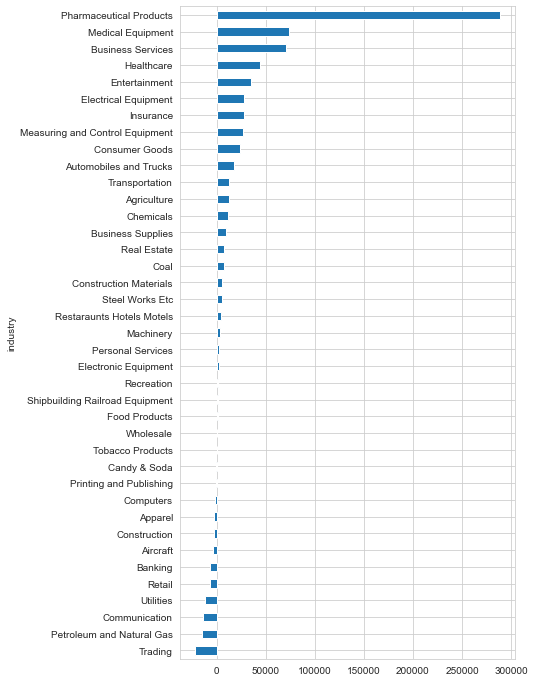

In [50]:
industries.dropna(how='all').sum(axis=1).sort_values().plot(kind='barh',figsize=(6,12))
plt.savefig('industries.pdf')